In [1]:
import numpy as np
import numpy.linalg as linalg
from discreteMarkovChain import markovChain

import sympy
sympy.init_printing(use_unicode=True)

In [2]:
P = np.matrix([
    [0.6, 0.2, 0.2], 
    [0.1, 0.8, 0.1],
    [0.1, 0.1, 0.8]])

(values,vectors) = linalg.eig(np.transpose(P))
print("values",values)
print("vectors\n",vectors)
indexOf1 = np.where(np.abs(values-1)<0.0001)[0][0]
s = vectors[:,indexOf1]
s = np.transpose(s / sum(s))
print("steady state probs", s)
print("s*P", s*P)

mc = markovChain(P)
mc.computePi('linear') #We can also use 'power', 'krylov' or 'eigen'
print("mc.pi", mc.pi)

values [ 0.5  1.   0.7]
vectors
 [[ -8.16496581e-01   3.33333333e-01  -8.45817455e-17]
 [  4.08248290e-01   6.66666667e-01  -7.07106781e-01]
 [  4.08248290e-01   6.66666667e-01   7.07106781e-01]]
steady state probs [[ 0.2  0.4  0.4]]
s*P [[ 0.2  0.4  0.4]]
mc.pi [ 0.2  0.4  0.4]


In [48]:
P1 = np.matrix([
    [0.5,0.5],
    [0.6,0.4]])

(values,vectors) = linalg.eig(np.transpose(P1))
print("values",values)
print("vectors\n",vectors)
indexOf1 = np.where(np.abs(values-1)<0.0001)[0][0]
s = vectors[:,indexOf1]
s = np.transpose(s / sum(s))
print("steady state probs", s)
print("s*P", s*P1)

mc = markovChain(P1)
mc.computePi('linear') #We can also use 'power', 'krylov' or 'eigen'
print("mc.pi", mc.pi)

values [ 1.  -0.1]
vectors
 [[ 0.76822128 -0.70710678]
 [ 0.6401844   0.70710678]]
steady state probs [[ 0.54545455  0.45454545]]
s*P [[ 0.54545455  0.45454545]]
mc.pi [ 0.54545455  0.45454545]


In [99]:
def steadyStateSym(transitionMatrix):
    """
    Given a transition matrix of a Markov chain, returns the steady-state vector
    Uses sympy for symbolic computaiton.
    
    INPUT: transitionMatrix - a list of rows each of which sums up to 1.
    OUTPUT steadyState - a sympy matrix; a row whose entires sum to 1.
    """
    P = sympy.Matrix(transitionMatrix)
    vects = P.T.eigenvects()
    s = [vect[2] for vect in vects if vect[0]==1][0][0].T
    s = sympy.simplify(s)
    s = (s/sum(s))
    s = sympy.simplify(s)
    return s

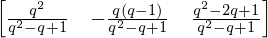

In [100]:
p,q = sympy.symbols('p q')
s = steadyStateSym([
    [q, 1-q, 0], 
    [q, 0, 1-q],
    [0, q, 1-q]])
s

In [3]:
sympy.simplify(s*P)

In [18]:
mat = np.zeros(3)
mat

array([ 0.,  0.,  0.])

In [34]:
def expectedPayment(w,p,q,A,B,kA,kB,kI,txCost,restartCost):
    transition = np.zeros((w+1,w+1))  # Markov process transition matrix
    payment = np.zeros(w+1)           # payment vector
    for k in range(0, kA):   # vanishes if kA=0 (never restart)
        transition[k,k] = 1-p-q
        transition[k,k+B] = q
        transition[k,kI-A] = p
        payment[k] = p*restartCost     # channel initialization
    for k in range(kA, A):  # vanishes if kA=A (never use blockchain)
        transition[k,k] = 1-q
        transition[k,k+B] = q
        payment[k] = p*txCost     # w.p. p, use bitcoin tx to remain in place
    for k in range(A,w-B+1):
        transition[k,k] = 1-p-q
        transition[k,k+B] = q
        transition[k,k-A] = p
    for k in range(w-B+1, kB+1): # vanishes if kB=w-B (never use blockchain)
        transition[k,k] = 1-p
        transition[k,k-A] = p
        payment[k] = q*txCost     # w.p. q, use bitcoin tx to remain in place
    for k in range(kB+1, w+1):  # disappears if kB=w (never restart)
        transition[k,k] = 1-p-q
        transition[k,kI+B] = q
        transition[k,k-A] = p
        payment[k] = q*restartCost     # channel initialization
        
    mc = markovChain(transition)
    mc.computePi('eigen') # can use 'linear' 'power', 'krylov' or 'eigen'
    steadyState = mc.pi
    expectedPayment = np.dot(payment,steadyState)
    return expectedPayment
        
ep = expectedPayment(w=100, p=.1, q=.9, A=10, B=1, kA=10, kB=99, kI=90, txCost=5, restartCost=10)
ep

In [50]:
def simulate(w,p,q,A,B,txCost,restartCost):
    eps = []
    for kA in [0,A]:
        for kB in [w,w-B]:
            for kI in [A, int(w/2), w-B]:
                ep = expectedPayment(w, p, q, A, B, kA, kB, kI, txCost, restartCost)
                print("kA={} kB={} kI={} ep={}".format(kA,kB,kI,ep))
                eps.append((kA,kB,kI,ep))
            print()
    i = np.argmin([ep[3] for ep in eps])
    best = eps[i]
    print("BEST: Alice uses blockchain in {}-{}, Bob restarts after {}, initialization at {}, payment {}".format(best[0],best[1],best[2],best[3]))

simulate(w=100, p=.1, q=.95, A=10, B=1, txCost=5, restartCost=10)

kA=0 kB=100 kI=10 ep=0.2029853321233756
kA=0 kB=100 kI=50 ep=0.2029853321233756
kA=0 kB=100 kI=99 ep=0.2029853321233756

kA=0 kB=99 kI=10 ep=0.06707861060419912
kA=0 kB=99 kI=50 ep=0.05863615996388098
kA=0 kB=99 kI=99 ep=0.36479017950826154

kA=10 kB=100 kI=10 ep=0.29475787425482014
kA=10 kB=100 kI=50 ep=0.2373843531586099
kA=10 kB=100 kI=99 ep=0.38592332458781176

kA=10 kB=99 kI=10 ep=0.20828645157085246
kA=10 kB=99 kI=50 ep=0.04065825264181202
kA=10 kB=99 kI=99 ep=0.7584627330436977

BEST: Alice restarts before 10, Bob restarts after 99, initialization at 50, payment 0.04065825264181202


In [4]:
from scipy.misc import comb
comb(20,4)

4845.0

In [12]:
comb(6,2)*comb(6,2)/comb(12,4)

0.45454545454545453